In [1]:
import os
import tensorflow as tf
import cv2 #checkout open cv
import imghdr #allows to check file extensions for images
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random
import shutil
#import scipy
from sklearn.model_selection import train_test_split
#import kaggle - will likely change

from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.models import sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
#from keras.applications import EfficientNetB0
from keras.layers.pooling.global_average_pooling2d import GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix

In [ ]:
path = '/kaggle/input/Validation'
os.mkdir(path)

In [2]:
testing_path = '/kaggle/input/tumor-set/archive/Testing'
training_path = '/kaggle/input/tumor-set/archive/Training'
validation_path = '/kaggle/input/tumor-set/archive/Validation'

In [14]:
testing_path = '/kaggle/input/brain-tumor-classification-mri/Testing'
training_path = '/kaggle/input/brain-tumor-classification-mri/Training'

In [15]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [16]:
x_train = [] 
y_train = [] 

x_test = []
y_test = []

size = 224

for i in labels:  
  # training set
  path = os.path.join(training_path, i)
  for file_name in os.listdir(path):
    img = cv2.imread(os.path.join(path, file_name))
    #img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    img = img.astype('float32') / 255.0
    x_train.append(img)
    y_train.append(i)

  # testing set
  path = os.path.join(testing_path, i)
  for file_name in os.listdir(path):
    img = cv2.imread(os.path.join(path, file_name))
    #img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    img = img.astype('float32') / 255.0
    x_test.append(img)
    y_test.append(i)

x_train = np.array(x_train)
y_train = np.array(y_train)
#y_train = to_categorical(np.array(y_train))

x_test = np.array(x_test)
y_test = np.array(y_test)
#y_test = to_categorical(np.array(y_test))

In [17]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=101)

In [20]:
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train, test_size=0.1,random_state=101)

In [22]:
#ONE HOT ENCODING
#CHANGE THIS LATER - ANOTHER EXAMPLE
y_train_valid = []
for i in y_train:
  y_train_valid.append(labels.index(i))
y_train = y_train_valid
y_train = to_categorical(y_train)

y_test_valid = []
for i in y_test:
  y_test_valid.append(labels.index(i))
y_test = y_test_valid
y_test = to_categorical(y_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


ValueError: array([0., 1., 0., 0.], dtype=float32) is not in list

In [7]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_delta=0.000, mode='auto', verbose=1)

In [8]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [23]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [24]:
tf_callback = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint("chckpnt.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [27]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(keras.layers.Dropout(0.2))

#model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(keras.layers.Dropout(0.2))

#model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(keras.layers.Dropout(0.2))

#model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
#model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Flatten())

#model.add(keras.layers.Dense(units=512, activation='relu'))
#model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(units=4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 128)     

In [28]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.1, callbacks=[reduce_lr, tf_callback, checkpoint])

Epoch 1/10
73/73 [==============================] - ETA: 0s - loss: 0.9278 - accuracy: 0.6028
Epoch 1: val_accuracy improved from -inf to 0.77992, saving model to chckpnt.h5
73/73 [==============================] - 144s 2s/step - loss: 0.9278 - accuracy: 0.6028 - val_loss: 0.6247 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 2/10
73/73 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.7913
Epoch 2: val_accuracy did not improve from 0.77992
73/73 [==============================] - 142s 2s/step - loss: 0.5294 - accuracy: 0.7913 - val_loss: 0.5779 - val_accuracy: 0.7606 - lr: 0.0010
Epoch 3/10
73/73 [==============================] - ETA: 0s - loss: 0.3963 - accuracy: 0.8365
Epoch 3: val_accuracy improved from 0.77992 to 0.85328, saving model to chckpnt.h5
73/73 [==============================] - 143s 2s/step - loss: 0.3963 - accuracy: 0.8365 - val_loss: 0.4028 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 4/10
73/73 [==============================] - ETA: 0s - loss: 0.2386 

In [30]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

9/9 [==============================] - 6s 622ms/step - loss: 0.3857 - accuracy: 0.9303
Test accuracy: 0.9303135871887207


9/9 [==============================] - 5s 553ms/step
[[88  4  0  0]
 [ 4 59  6  2]
 [ 0  1 41  2]
 [ 1  0  0 79]]


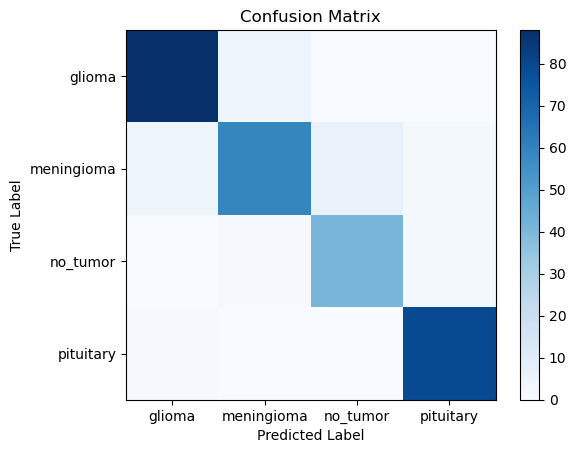

In [29]:
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(model.predict(x_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(cm)
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1, 2, 3], ['glioma', 'meningioma', 'no_tumor', 'pituitary'])
plt.yticks([0, 1, 2, 3], ['glioma', 'meningioma', 'no_tumor', 'pituitary'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

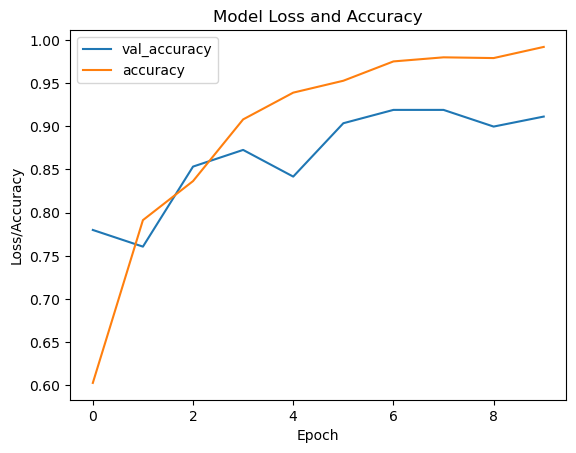

In [31]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(['val_accuracy', 'accuracy'], loc='upper left')
plt.show()

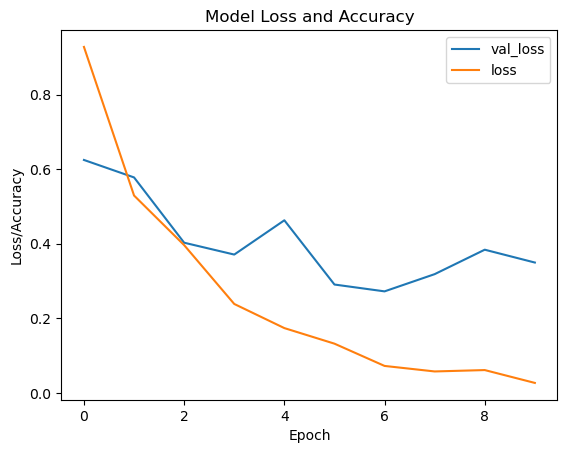

In [32]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'loss'], loc='upper right')
plt.show()

In [33]:
#EXPERIMENTAL
model.save('/kaggle/working/bt_ai_EXP3-91acc-04lss-08-04-23.h5')